In [1]:
import pandas as pd
import seaborn as sns

In [2]:
flights = pd.read_parquet('flights.parquet')
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191805 entries, 0 to 1191804
Data columns (total 33 columns):
TRANSACTIONID        1191805 non-null int64
FLIGHTDATE           1191805 non-null datetime64[ns]
AIRLINECODE          1191805 non-null object
AIRLINENAME          1191805 non-null object
TAILNUM              1034988 non-null object
FLIGHTNUM            1191805 non-null int64
ORIGINAIRPORTCODE    1191805 non-null object
ORIGAIRPORTNAME      1191805 non-null object
ORIGINCITYNAME       1191805 non-null object
ORIGINSTATE          1191805 non-null object
ORIGINSTATENAME      1191805 non-null object
DESTAIRPORTCODE      1191805 non-null object
DESTAIRPORTNAME      1191805 non-null object
DESTCITYNAME         1191805 non-null object
DESTSTATE            1191805 non-null object
DESTSTATENAME        1191805 non-null object
CRSDEPTIME           1191805 non-null object
DEPTIME              1163470 non-null object
DEPDELAY             1163470 non-null float64
TAXIOUT              1011

## Questions
- Top 10 airports in terms of traffic (outgoing and incoming)
- Top 10 states in terms of traffic (outgoing and incoming)
- Top 10 airports where there is maximum delay
- Top 10 airlines in terms of departure delay
- Top 10 longest routes
- Top 3 airlines which gets cancelled a lot

### Top 10 airports
We can see below that the top 3 airports are Hartsfield-Jackson Atlanta International, Chicago O'Hare International and Dallas/Fort Worth International

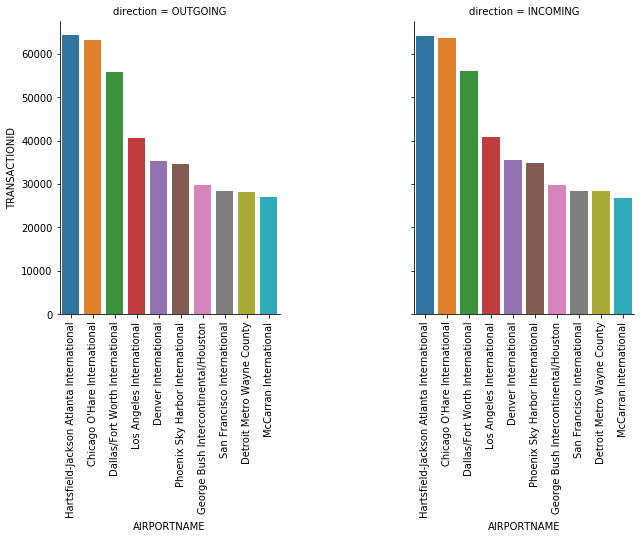

In [46]:
top10_origin_airport = flights.groupby('ORIGAIRPORTNAME', as_index=False).\
agg({'TRANSACTIONID': 'count'}).\
sort_values('TRANSACTIONID', ascending=False).head(10)
top10_origin_airport['direction'] = 'OUTGOING'
top10_origin_airport = top10_origin_airport.rename(columns = {'ORIGAIRPORTNAME': 'AIRPORTNAME'})

top10_dest_airport = flights.groupby('DESTAIRPORTNAME', as_index=False).\
agg({'TRANSACTIONID': 'count'}).\
sort_values('TRANSACTIONID', ascending=False).head(10)
top10_dest_airport['direction'] = 'INCOMING'
top10_dest_airport = top10_dest_airport.rename(columns = {'DESTAIRPORTNAME': 'AIRPORTNAME'})

top10_airport = top10_origin_airport.append(top10_dest_airport)
top10_airport = top10_airport.reset_index(drop=True)
# top10_airport

g = sns.catplot(x='AIRPORTNAME', y='TRANSACTIONID', data=top10_airport, col='direction', kind='bar')
g.set_xticklabels(labels=top10_airport.AIRPORTNAME, rotation=90)

### Top 10 states
We can see below that the top 3 states are California, Texas and Illinois. Both outgoing and incoming traffic are almost similar. We saw above that the second highest traffic airport was O'Hare but in terms of traffic state-wide, Texas has more traffic that Illinois. There might be other airports in Texas that count for more traffic.

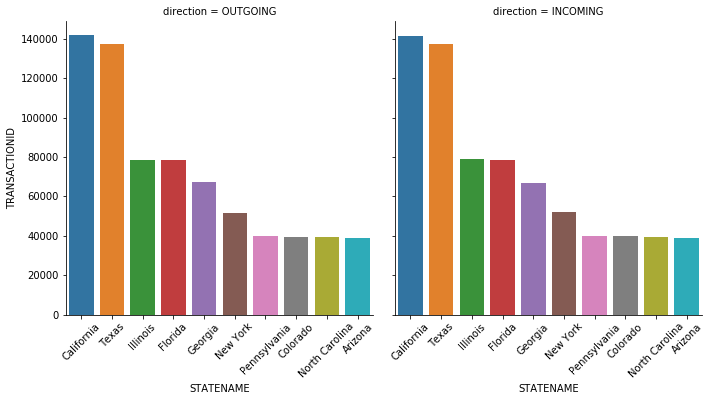

In [48]:
top10_origin_state = flights.groupby('ORIGINSTATENAME', as_index=False).\
agg({'TRANSACTIONID': 'count'}).\
sort_values('TRANSACTIONID', ascending=False).head(10)
top10_origin_state['direction'] = 'OUTGOING'
top10_origin_state = top10_origin_state.rename(columns = {'ORIGINSTATENAME': 'STATENAME'})

top10_dest_state = flights.groupby('DESTSTATENAME', as_index=False).\
agg({'TRANSACTIONID': 'count'}).\
sort_values('TRANSACTIONID', ascending=False).head(10)
top10_dest_state['direction'] = 'INCOMING'
top10_dest_state = top10_dest_state.rename(columns = {'DESTSTATENAME': 'STATENAME'})

top10_state = top10_origin_state.append(top10_dest_state)
top10_state = top10_state.reset_index(drop=True)
# top10_state

g = sns.catplot(x='STATENAME', y='TRANSACTIONID', data=top10_state, col='direction', kind='bar')
g.set_xticklabels(labels=top10_state.STATENAME, rotation=45)

In [49]:
flights.groupby('ORIGAIRPORTNAME').agg({'DEPDELAY':'sum'}).sort_values('DEPDELAY', ascending=False).head(10)

,DEPDELAY
ORIGAIRPORTNAME,
Chicago O'Hare International,663806.0
Hartsfield-Jackson Atlanta International,538460.0
Dallas/Fort Worth International,466935.0
Denver International,297215.0
Los Angeles International,278899.0
San Francisco International,264173.0
Phoenix Sky Harbor International,249876.0
Newark Liberty International,237504.0
Detroit Metro Wayne County,221963.0
